# Experiment: electrical circuits

This notebook will cover the experiment in chapter 5

In [70]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

We want to solve the equation 

- x'' = -x -g(x)x'

which models an electrical circuit with a resistor, a capacitor, and an inductor (in that order). Equations of this form are called Lienard equations.

To solve it will introduce a new numerical method, Runge-Kutta-Fehlberg 45, also know as RKF45.

## RKF45

In [269]:
a = np.array([
    [1/4, 0, 0, 0, 0],
    [3/32, 9/32, 0, 0, 0],
    [1932/2197, -7200/2197, 7296/2197, 0, 0],
    [439/216, -8, 3680/513, -845/4104, 0],
    [-8/27, 2, -3544/2565, 1859/4104, -11/40]
])
b4 = np.array([25/216, 0, 1408/2565, 2197/4104, -1/5, 0])
b5 = np.array([16/135, 0, 6656/12825, 28561/56430, -9/50, 2/55])
c = np.array([0, 1/4, 3/8, 12/13, 1, 1/2])

In [270]:
MAX_ERROR = 1e-6
MIN_STEP = 1e-4
MAX_STEP = 5e-1

It might be wise to add a minimum value for h or a maximum number of iterations for the same step. Without that the function RKF45_step might run into infinite loops.

In [275]:
def RKF45_step(F, x, t, h):
    dim = len(x)
    l = len(c)
    k = np.zeros((l, dim))

    k[0] = h * F(t, x)
    for i in range(1, l):
        k[i] = h * F(t + c[i] * h, x + np.dot(a[i-1, :i], k[:i]))
    # Compute next time
    t_next = t + h

    # Compute next x with order 4 and 5 methods
    x4 = x + np.dot(b4, k)
    x5 = x + np.dot(b5, k)

    # Compute error
    error = np.linalg.norm(x4 - x5)

    # Update h
    h_next = h * np.power(MAX_ERROR / (2 * error), 1/4)

    # Return computation or repeat with finer approximation
    if error <= MAX_ERROR or h_next < MIN_STEP or h_next > MIN_STEP:
        return t_next, x4, h_next
    else:
        return RKF45_step(F, x, t, h)

In [276]:
def RKF45(F, t0, x0, h0, n_steps):
    # Initialize stuff
    dim = len(x0)
    t = np.zeros((n_steps))
    x = np.zeros((n_steps, dim))
    h = np.zeros((n_steps))
    t[0], x[0], h[0] = t0, x0, h0

    for n in range(1, n_steps):
        t[n], x[n], h[n] = RKF45_step(F, x[n-1], t[n-1], h[n-1])
        
    return t, x, h

## Solving the Lienard equations

In [344]:
def g(x):
    return x**2 - 1

def simple_lienard(t, x):
    x1, x2 = x
    Dx1 = x2
    Dx2 = -x1 - g(x1) * x2
    return np.array([Dx1, Dx2])

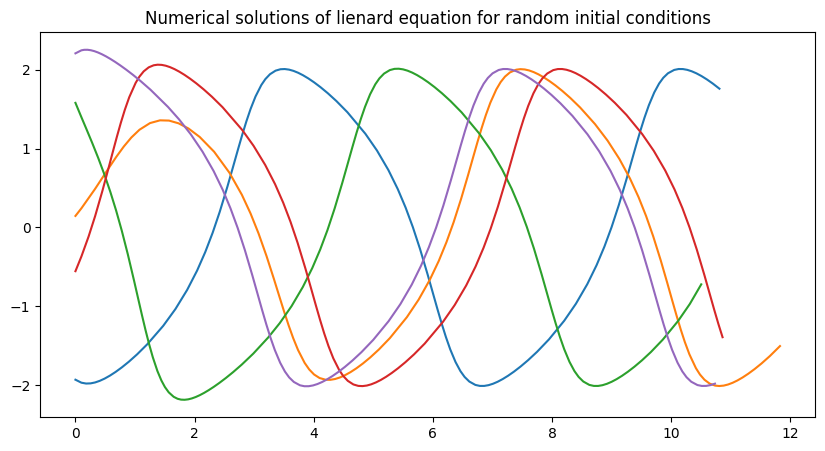

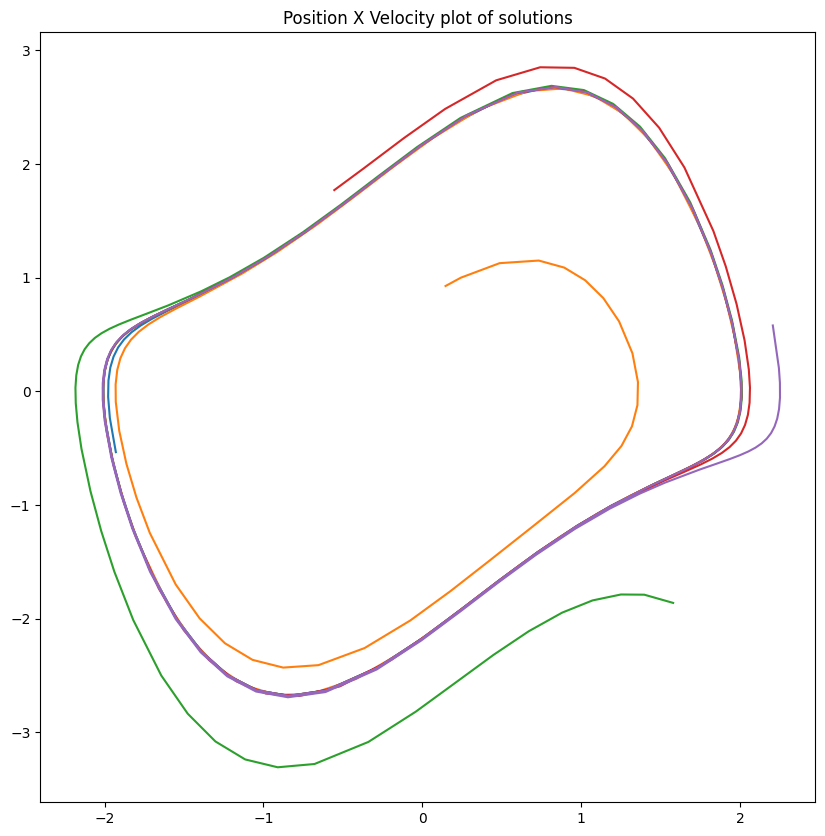

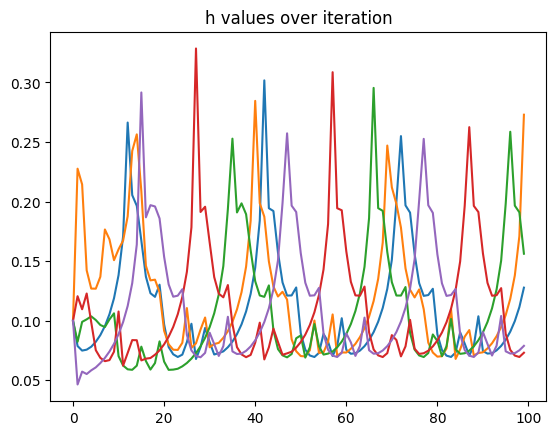

In [400]:
initial_values = np.random.uniform(-3, 3, (5, 2))

_, ax_1d = plt.subplots(figsize=(10, 5))
_, ax_2d = plt.subplots(figsize=(10, 10))
_, ax_h = plt.subplots()

ax_1d.set_title("Numerical solutions of lienard equation for random initial conditions")
ax_2d.set_title("Position X Velocity plot of solutions")
ax_h.set_title("h values over iteration")

solutions = [RKF45(simple_lienard, 0, x, 0.1, 100) for x in initial_values]
for t, x, h in solutions:
    ax_1d.plot(t[:], x[:, 0])
    ax_2d.plot(x[:, 0], x[:, 1])
    ax_h.plot(h)
plt.show()

Now let's move on to a more complex version of the Lienard equation.

In [362]:
mus = [1/10, 1/5, 1/2, 2, 5, 10]

def create_lienard_system(mu):
    def lienard(t, x):
        x1, x2 = x
        dx1 = x2
        dx2 = -x1 - mu * (x1**2 - 1) * x2
        return np.array([dx1, dx2])
    
    return lienard

lienard_systems = [create_lienard_system(mu) for mu in mus]

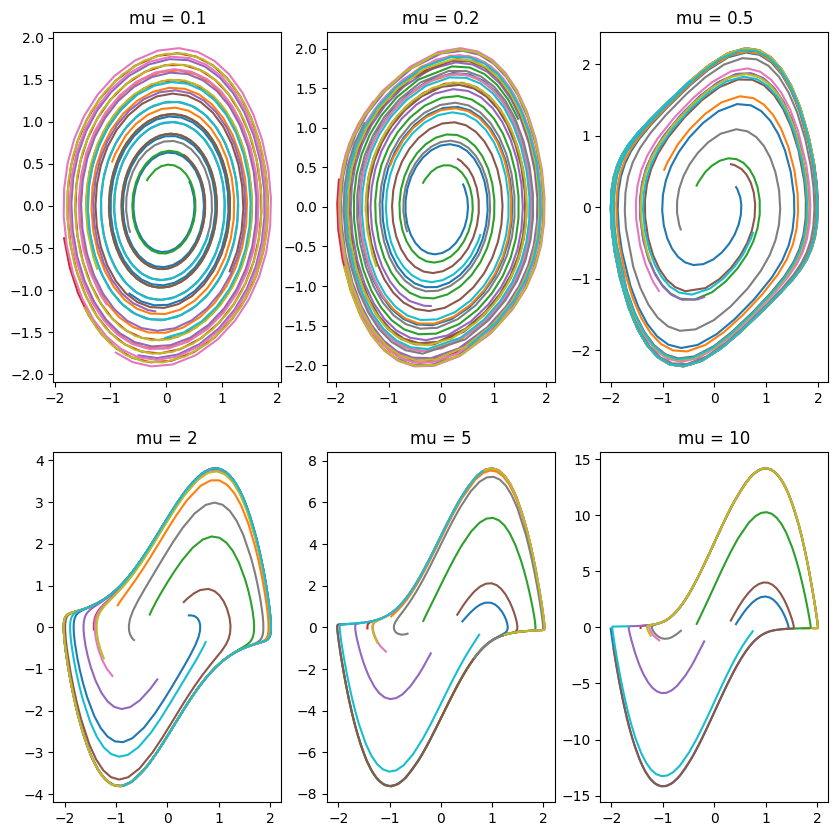

In [368]:
initial_values = np.random.uniform(-1.5, 1.5, (10, 2))

_, axs = plt.subplots(2, 3, figsize=(10, 10))
for i in range(6):
    axs[i//3, i%3].set_title(f"mu = {mus[i]}")

for i in range(6):
    solutions = [RKF45(lienard_systems[i], 0, x, 0.1, 100) for x in initial_values]
    for _, x, _ in solutions:
        axs[i//3, i%3].plot(x[:, 0], x[:, 1])
plt.show()

## Compare with RK4

In [366]:
# General Runge-Kutta method
def RK_method(F, t_span, x0, n_steps, a, b, c):
    dim = len(x0)
    l = len(b)
    t_start, t_end = t_span
    t_step = (t_end - t_start) / (n_steps - 1)

    t = np.linspace(t_start, t_end, n_steps)
    x = np.zeros((n_steps, dim))
    x[0] = x0
    k = np.zeros((l, dim))

    for n in range(1, n_steps):
        k[0] = F(t[n-1], x[n-1])
        for i in range(1, l):
            t_i = t[n-1] + t_step * c[i]
            x_i = x[n-1] + t_step * np.dot(a[i-1][:i], k[:i])
            k[i] = F(t_i, x_i)
        x[n] = x[n-1] + t_step * np.dot(b, k)

    return t, x

# Classical (4-stage) Runge-Kutta
def RK4(F, t_span, x0, n_steps):
    a = np.array(
        [[0.5, 0, 0],
         [0, 0.5, 0],
         [0, 0, 1]]
    )
    b = np.array([1/6, 2/6, 2/6, 1/6])
    c = np.array([0, 0.5, 0.5, 1])
    return RK_method(F, t_span, x0, n_steps, a, b, c)

Let's compare the two!

### Lienard again

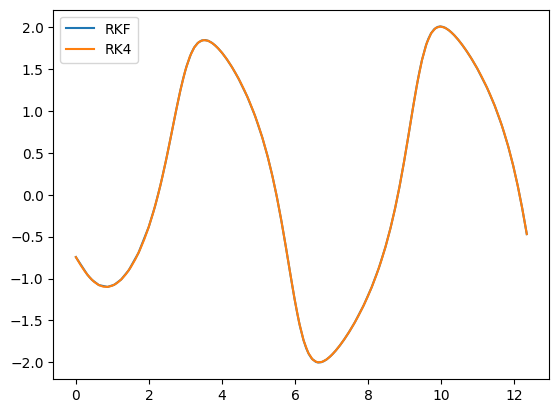

In [399]:
initial_value = np.random.uniform(-1, 1, (2))

t_rkf, x_rkf, _ = RKF45(simple_lienard, 0, initial_value, 0.01, 100)
t_rk4, x_rk4 = RK4(simple_lienard, (t_rkf[0], t_rkf[-1]), initial_value, 100)
plt.plot(t_rkf, x_rkf[:, 0], label="RKF")
plt.plot(t_rk4, x_rk4[:, 0], label="RK4")
plt.legend()
plt.show()

There's absolutely no difference with the simple Lienard. Let's check if this holds for the more complicated ones.

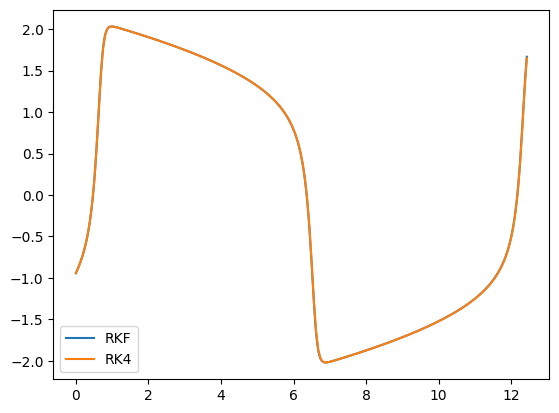

In [413]:
lienard_10 = create_lienard_system(5)

initial_value = np.random.uniform(-1, 1, (2))

t_rkf, x_rkf, _ = RKF45(lienard_10, 0, initial_value, 0.1, 200)
t_rk4, x_rk4 = RK4(lienard_10, (t_rkf[0], t_rkf[-1]), initial_value, 200)
plt.plot(t_rkf, x_rkf[:, 0], label="RKF")
plt.plot(t_rk4, x_rk4[:, 0], label="RK4")
plt.legend()
plt.show()

Yeah idk RK4 is awesome. Maybe in a more complex simulation I'd see changes? What about with the Lorenz attractor?

### Lorenz again

In [428]:
# Parameters of the Lorenz attractor
s, r, u = 10, 28, 8/3

def lorenz(t, X):
    x, y, z = X
    Dx = -s * x + s * y
    Dy = r * x - y - x * z
    Dz = x * y - u * z
    return np.array([Dx, Dy, Dz])

In [436]:
# Initial condition
t_span = (0, 30)
t0, t_end = t_span
X0 = [1, 0, .5]
n_steps = 3000
start_step = 0
h0 = 0.1

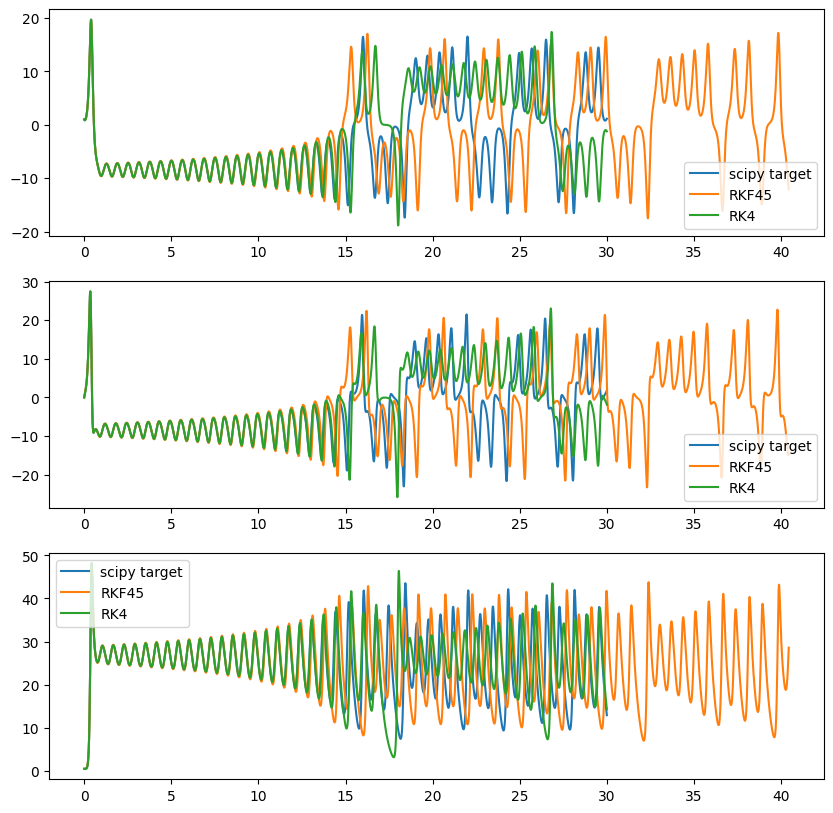

In [437]:
_, lorenz_ax = plt.subplots(3, figsize=(10, 10))

# scipy solution
sol_scipy = solve_ivp(lorenz, t_span, X0, t_eval=np.linspace(t0, t_end, n_steps))
t_target, x_target = sol_scipy.t, sol_scipy.y

# RKF45 solution
t_rkf, x_rkf, _ = RKF45(lorenz, t0, X0, h0, n_steps)

# RK4 solution
t_rk4, x_rk4 = RK4(lorenz, t_span, X0, n_steps)

for i in range(3):
    lorenz_ax[i].plot(t_target[start_step:], x_target[i, start_step:], label="scipy target")
    lorenz_ax[i].plot(t_rkf[start_step:], x_rkf[start_step:, i], label="RKF45")
    lorenz_ax[i].plot(t_rk4[start_step:], x_rk4[start_step:, i], label="RK4")
    lorenz_ax[i].legend()

Lorenz is just a mess.